# EXAMPLE: 
# USING coralign.util.center.center_of_energy() FOR FOCAL PLANE ALIGNMENT

### IMPORTS

In [1]:
import sys
sys.path.insert(0,"../")

import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt

from coralign.util import shapes, mft, center

### FUNCTIONS FOR GENERATION OF SIMULATED FOCAL PLANE

In [2]:
def gen_pupil(pupil_x_shear, pupil_y_shear, print_figure=False):
    # %% Pupil Generation

    Nbeam = 100
    nx = 150
    ny = nx
    xOffset = pupil_x_shear
    yOffset = pupil_y_shear
    diamInner = 0.20*Nbeam
    diamOuter = 1.00*Nbeam
    strutAngles = np.array([0, 90, 180, 270]) + 15
    strutWidth = 0.03*Nbeam
    pupil = shapes.simple_pupil(nx, ny, xOffset, yOffset, diamInner, diamOuter,
                                strutAngles=strutAngles, strutWidth=strutWidth)

    if print_figure is True:
        plt.figure(1)
        plt.imshow(pupil)
        plt.colorbar()
        plt.gca().invert_yaxis()
        plt.title("PUPIL")
        plt.pause(0.1)
        
    return pupil

In [3]:
def gen_psf(pupil, print_figure=False):

    # %% PSF Generation
    
    Nbeam = 100
    
    fl = 1
    wavelength = 1
    dx = 1/Nbeam

    ppl = 4  # pixels per lambda/D
    dxi = 1/ppl  # meters per pixel at focus in x
    deta = dxi  # meters per pixel at focus in y

    Nxi = 200
    Neta = Nxi

    Efocus = mft.do_mft(pupil, (Neta, Nxi), ppl, Nbeam)
    Ifocus = np.abs(Efocus)**2
    Ifocus = Ifocus/np.max(Ifocus)

    if print_figure is True:
        plt.figure(2)
        plt.imshow(np.log10(Ifocus))
        plt.clim(-5, 0)
        plt.colorbar()
        plt.gca().invert_yaxis()
        plt.title("PSF")
        plt.pause(0.1)
    
    return Ifocus
    

In [4]:
def gen_fpm_and_apply_to_psf(Ifocus, fpm_x_shear, fpm_y_shear, print_figure=False):
    # %% Focal Plane Mask Generation, then application (just multiplication) to the PSF
    
    ppl = 4  # pixels per lambda/D
    Nxi = 200
    Neta = Nxi
    
    nx = Nxi
    ny = Neta
    radius = 2.8*ppl
    xOffset = fpm_x_shear*ppl
    yOffset = fpm_y_shear*ppl
    fpm = shapes.circle(nx, ny, radius, xOffset, yOffset, isDark=True)

    Imasked = Ifocus * fpm

    # # Shift the whole image*fpm
    # yOffsetImage = 5.5  # pixels
    # xOffsetImage = -10.2
    # Imasked = scipy.ndimage.shift(Imasked, (yOffsetImage, xOffsetImage))

    if print_figure is True:
        plt.figure(3)
        plt.imshow(fpm)
        plt.colorbar()
        plt.gca().invert_yaxis()
        plt.title("FOCAL PLANE MASK")
        plt.pause(0.1)
        
        plt.figure(4)
        plt.imshow(np.log10(Imasked))
        plt.clim(-5, 0)
        plt.colorbar()
        plt.gca().invert_yaxis()
        plt.title("FOCAL PLANE")
        plt.pause(0.1)
    
    return Imasked

In [5]:
# %% Apply noise to the images

def add_focal_plane_noise(Imasked, image_noise_factor, print_figure=False):
    IfocusNoisy = Imasked + image_noise_factor*np.random.randn(Imasked.shape[0], Imasked.shape[1])

    if print_figure is True:
        plt.figure(6)
        plt.imshow(np.log10(IfocusNoisy))
        plt.clim(-5, 0)
        plt.colorbar()
        plt.gca().invert_yaxis()
        plt.title('FOCAL PLANE WITH NOISE')
        plt.pause(0.1)
        
    return IfocusNoisy

### EXAMPLE OF FUNCTION TO PERFORM FPM ALIGNMENT 

In [6]:
def simulate_center_of_energy_balance_alignment(Ifocus, fpm_x_shear, fpm_y_shear, image_noise_factor, const, print_figure=False):
    
    fpm_x_center_true = 0
    fpm_y_center_true = 0
    
    masked_focus = gen_fpm_and_apply_to_psf(Ifocus, fpm_x_shear, fpm_y_shear)
    noisy_masked_focus = add_focal_plane_noise(masked_focus, image_noise_factor, print_figure)
    computed_mask = noisy_masked_focus
    
    x_diff, y_diff = float("inf"), float("inf")
    iterations = 0
    
    while ((abs(fpm_x_center_true - fpm_x_shear) > 0.25/8 or abs(fpm_y_center_true - fpm_y_shear) > 0.25/8) and iterations < 20):
        
        avg_col, avg_row = center.center_of_energy(computed_mask)
        
        x_diff = avg_col - 100 # index of origin is 100
        y_diff = avg_row - 100 # index of origin is 100
        
        fpm_x_shear += x_diff / const
        fpm_y_shear += y_diff / const
        
        computed_mask = gen_fpm_and_apply_to_psf(Ifocus, fpm_x_shear, fpm_y_shear)
        
        computed_mask = add_focal_plane_noise(computed_mask, image_noise_factor, print_figure)

        iterations += 1
    
    return iterations

### EXAMPLE OF FUNCTION TO OPTIMIZE CONSTANT FOR FPM ALIGNMENT

In [7]:
def find_optimal_const(Ifocus, fpm_x_shear, fpm_y_shear, image_noise_factor, range_limit, print_figure=False, print_iteration_num=False):
    min_num_iterations = float("inf")
    optimal_const = -1
    const = 0.50
    
    while const < range_limit:
    
        num_iterations = simulate_center_of_energy_balance_alignment(Ifocus, fpm_x_shear, fpm_x_shear, image_noise_factor, const, print_figure)
        
        if(print_iteration_num is True):
            print("CONSTANT" , const, "TOOK", num_iterations, "ITERATIONS TO CONVERGE.")
        
        if num_iterations < min_num_iterations:
            min_num_iterations = num_iterations
            optimal_const = const
        
        const += 0.05
    return optimal_const, min_num_iterations

### MODIFIABLE PARAMETERS

In [8]:
# FOCAL PLANE MASK (FPM)
fpm_x_shear = 2  # in units of lambda/D
fpm_y_shear = 1  # in units of lambda/D

# NOISE FACTOR
image_noise_factor = 1e-5

# CONSTANT
optimization_range_limit = 3.05

### GENERATE FPM PSF (SIMULATION)

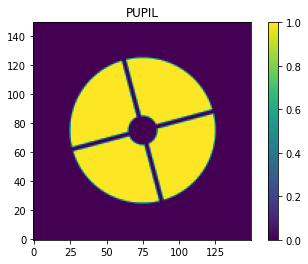

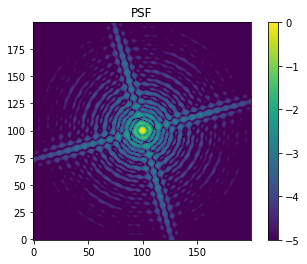

In [9]:
pupil_x_shear = 0  # in units of pupil diameters
pupil_y_shear = 0  # in units of pupil diameters

pupil = gen_pupil(pupil_x_shear, pupil_y_shear, True)
Ifocus = gen_psf(pupil, True)

### OPTIMIZE CONSTANT VALUE FOR FPM ALIGNMENT

In [10]:
optimal_const, min_num_iterations = find_optimal_const(Ifocus, fpm_x_shear, fpm_y_shear, image_noise_factor, optimization_range_limit, print_iteration_num = True)
min_num_it_str = "(" + str(min_num_iterations) + " ITERATION(S))"
print("OPTIMAL CONSTANT:", optimal_const, min_num_it_str)

CONSTANT 0.5 TOOK 18 ITERATIONS TO CONVERGE.
CONSTANT 0.55 TOOK 5 ITERATIONS TO CONVERGE.
CONSTANT 0.6000000000000001 TOOK 14 ITERATIONS TO CONVERGE.
CONSTANT 0.6500000000000001 TOOK 3 ITERATIONS TO CONVERGE.
CONSTANT 0.7000000000000002 TOOK 11 ITERATIONS TO CONVERGE.
CONSTANT 0.7500000000000002 TOOK 19 ITERATIONS TO CONVERGE.
CONSTANT 0.8000000000000003 TOOK 5 ITERATIONS TO CONVERGE.
CONSTANT 0.8500000000000003 TOOK 6 ITERATIONS TO CONVERGE.
CONSTANT 0.9000000000000004 TOOK 7 ITERATIONS TO CONVERGE.
CONSTANT 0.9500000000000004 TOOK 17 ITERATIONS TO CONVERGE.
CONSTANT 1.0000000000000004 TOOK 6 ITERATIONS TO CONVERGE.
CONSTANT 1.0500000000000005 TOOK 11 ITERATIONS TO CONVERGE.
CONSTANT 1.1000000000000005 TOOK 8 ITERATIONS TO CONVERGE.
CONSTANT 1.1500000000000006 TOOK 15 ITERATIONS TO CONVERGE.
CONSTANT 1.2000000000000006 TOOK 7 ITERATIONS TO CONVERGE.
CONSTANT 1.2500000000000007 TOOK 7 ITERATIONS TO CONVERGE.
CONSTANT 1.3000000000000007 TOOK 6 ITERATIONS TO CONVERGE.
CONSTANT 1.35000000

### SIMULATE ALIGNMENT OF FPM

/var/folders/43/xbbbyqqn69zf_p3kqw1fxk680000gq/T/ipykernel_50087/895685108.py:8: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(IfocusNoisy))


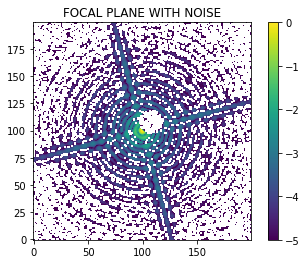

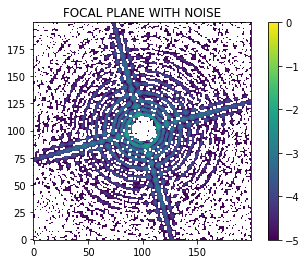

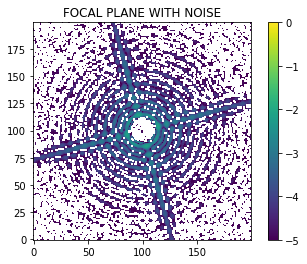

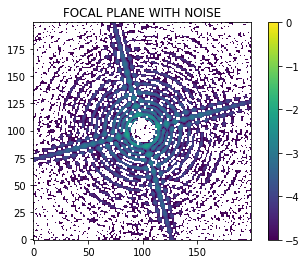

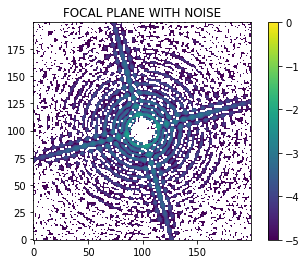

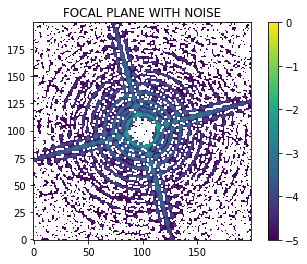

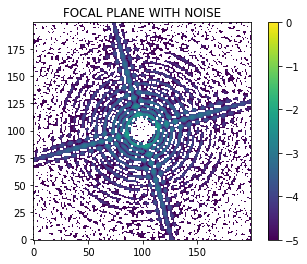

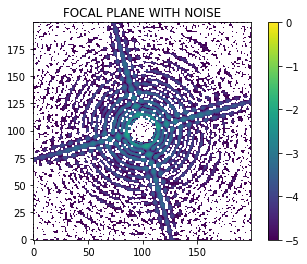

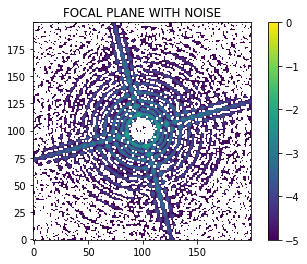

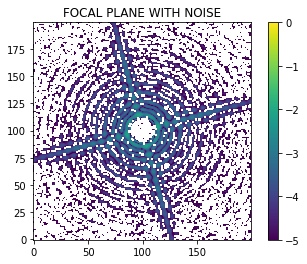

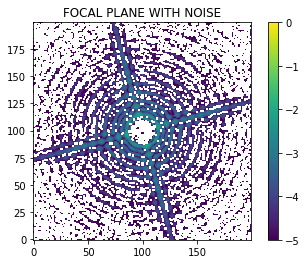

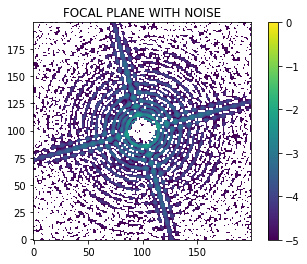

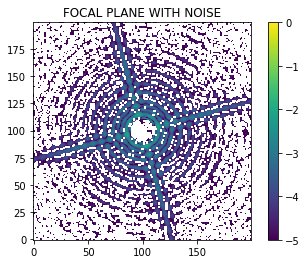

ITERATIONS UNTIL CONVERGENCE: 12


In [11]:
num_iterations = simulate_center_of_energy_balance_alignment(Ifocus, fpm_x_shear, fpm_x_shear, image_noise_factor, optimal_const, True)
print("ITERATIONS UNTIL CONVERGENCE:", num_iterations)